need to do - review colours for red, green and yellow
improve x-y coordinate stuff
work on get force stuff!

For some reason my shit is not working - might have to try simple approach of just going over it?

get rotate going!!

Get funny eyes!

In [24]:
# Import all libraries!
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import time
from urx.robotiq_two_finger_gripper import Robotiq_Two_Finger_Gripper
import logging
import urx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
# from urx.urrtmon import URRTMonitor



cam_init_pos = [-0.00043183961977177887, -1.651595417653219, -1.226389233266012, -1.276344124470846, -4.72298783460726, 0.001785649568773806]
bucket_pos = [1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276]
hardcode_object_loc = [-0.024045769368306935, -1.8617809454547327, -1.511141602193014, -1.4511950651751917, -4.672266546879904, 0.047373268753290176]
bucket_pick = [-0.04573041597475225, -1.8159015814410608, -1.2815788427936, -1.4384973684894007, -4.67054266134371, 0.04719312861561775]

high_point = [0.90383380651474, -1.4072287718402308, -0.237281624470846, -0.17934972444643194, -4.722544852887289, -0.05534726778139287]

In [25]:
rob = urx.Robot("192.168.1.6", use_rt=True)
a = 0.7; v = 2

# rob_force = URRTMonitor(rob)
t = 0
while t < 100:
    print(rob.get_tcp_force())
    time.sleep(1)
    t+=1


rob.close()

[21.05168236  8.43653878  7.87423503  0.3954561   2.366771   -0.82013392]
[23.29336501  7.80337926 10.20227891  0.42683938  2.83226436 -0.87625749]
[21.86954264  8.78979039  8.63047369  0.3631316   2.59421105 -0.92979815]
[ 19.12215661   8.66410792 -54.33939248   0.27173568  -5.32763695
  -0.87112489]
[ 19.59286551  -2.30566509 -65.40906673   0.93981375  -6.76921377
  -0.4153595 ]
[ 18.27933321  -2.07766057 -68.17149001   0.99981224  -7.15268282
  -0.3899885 ]
[ 9.73761476  2.84448861 13.51668158  0.76160843  2.6070752  -0.74966372]
[ 8.44662111 10.05541749 13.5188629   0.32865805  2.77262928 -0.93669343]
[ 7.53866959 10.10438505 12.43190554  0.2794672   2.59040871 -0.94755855]
[ 9.25029451  9.36205109 15.00666123  0.28605522  3.30999499 -0.97112556]
[ 8.29436241 10.23986273 13.32535051  0.30761191  2.74562609 -0.93209529]
[ 8.54224563 10.03691226 13.88823026  0.28206945  2.80598472 -0.96620451]
[ 9.65664156 10.69694378 14.06972214  0.22960998  2.66078101 -1.01408691]
[ 8.30933321 10.5

moved to init position
moved to init position


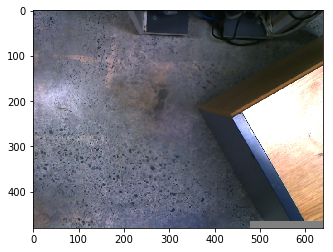

image recieved
pixel count: 0
no more objects in scene of colour: green
finishing program


In [47]:
# just get red
####################
%matplotlib inline

# initalise
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.7; v = 2

robotiqgrip.open_gripper()
go_to_start(rob)

while True:
    go_to_start(rob)
    time.sleep(2)
    get_image()
    distance = detect_photos('green')
    
    if distance == None:
        print("finishing program")
        break
        
    [x_dist, y_dist] = convert_to_mm(distance[0], distance[1])


    rob.translate(((y_dist)-0.095, x_dist, -0.33), acc=a, vel=v)

    robotiqgrip.close_gripper()
    rob.movejs([cam_init_pos, bucket_pos], acc = a, vel = v, radius=0.2)
    robotiqgrip.open_gripper()

In [78]:
def change_coordinates(x, y, n):
    if n == 0:
        rob.translate((0, x, 0), acc=a, vel=v)
        rob.translate((0, -x, 0), acc=a, vel=v)

        rob.translate((y, 0, 0), acc=a, vel=v)
        rob.translate((-y, 0, 0), acc=a, vel=v)
        
    if n == 45:
#         rob.translate((-math.tan(0.785398) * x, x/math.cos(0.785398), 0), acc=a, vel=v)
#         rob.translate((math.tan(0.785398) * x, -x/math.cos(0.785398), 0), acc=a, vel=v)

#         rob.translate((y/math.cos(0.785398), math.tan(0.785398) * y, 0), acc=a, vel=v)
#         rob.translate((-y/math.cos(0.785398), -math.tan(0.785398) * y, 0), acc=a, vel=v)
        
        rob.translate((-math.tan(0.785398) * x, x/math.cos(0.785398), 0), acc=a, vel=v)
        rob.translate((y/math.cos(0.785398), math.tan(0.785398) * y, 0), acc=a, vel=v)
        rob.translate((-0.02/math.cos(0.785398), math.tan(0.785398) * -0.02, 0), acc=a, vel=v)
        rob.translate((0,0, -0.33), acc=a, vel=v)
        
    if n == 90:
        rob.translate((-x, 0, 0), acc=a, vel=v)
        rob.translate((x, 0, 0), acc=a, vel=v)

        rob.translate((0, y, 0), acc=a, vel=v)
        rob.translate((0, -y, 0), acc=a, vel=v)
        
    if n == 135:
        rob.translate((x/math.cos(0.785398*3), math.tan(0.785398*3) * x, 0), acc=a, vel=v)
        rob.translate((-x/math.cos(0.785398*3), -math.tan(0.785398*3) * x, 0), acc=a, vel=v)

        rob.translate((math.tan(0.785398*3) * y, -y/math.cos(0.785398*3), 0), acc=a, vel=v)
        rob.translate((-math.tan(0.785398*3) * y, y/math.cos(0.785398*3), 0), acc=a, vel=v)
        
    if n == 180:
        rob.translate((0, -x, 0), acc=a, vel=v)
        rob.translate((0, x, 0), acc=a, vel=v)

        rob.translate((-y, 0, 0), acc=a, vel=v)
        rob.translate((y, 0, 0), acc=a, vel=v)
        
    if n == 225:
#         rob.translate((math.tan(0.785398) * x, -x/math.cos(0.785398), 0), acc=a, vel=v)
#         rob.translate((-math.tan(0.785398) * x, y/math.cos(0.785398), 0), acc=a, vel=v)

#         rob.translate((-y/math.cos(0.785398), -math.tan(0.785398) * y, 0), acc=a, vel=v)
#         rob.translate((y/math.cos(0.785398), math.tan(0.785398) * y, 0), acc=a, vel=v)
        
        rob.translate((math.tan(0.785398) * x, -x/math.cos(0.785398), 0), acc=a, vel=v)
        rob.translate((-y/math.cos(0.785398), -math.tan(0.785398) * y, 0), acc=a, vel=v)
        rob.translate((0.07/math.cos(0.785398), math.tan(0.785398) * 0.07, 0), acc=a, vel=v)
        rob.translate((0,0, -0.33), acc=a, vel=v)
        
    if n == 270:
        rob.translate((x, 0, 0), acc=a, vel=v)
        rob.translate((-x, 0, 0), acc=a, vel=v)

        rob.translate((0, -y, 0), acc=a, vel=v)
        rob.translate((0, y, 0), acc=a, vel=v)
        
    if n == 315:
        rob.translate((-x/math.cos(0.785398*3), -math.tan(0.785398*3) * x, 0), acc=a, vel=v)
        rob.translate((x/math.cos(0.785398*3), math.tan(0.785398*3) * x, 0), acc=a, vel=v)

        rob.translate((-math.tan(0.785398*3) * y, y/math.cos(0.785398*3), 0), acc=a, vel=v)
        rob.translate((math.tan(0.785398*3) * y, -y/math.cos(0.785398*3), 0), acc=a, vel=v)

        

        
        

In [23]:
rob = rob_connect()

print(rob.getj())

rob.close()

[0.90383380651474, -1.4072287718402308, -0.237281624470846, -0.17934972444643194, -4.722544852887289, -0.05534726778139287]


In [72]:
#### trying at 90 degrees

rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 1.5; v = 2
robotiqgrip.open_gripper()
go_to_start(rob)
rob.translate((0, 0.1, 0), acc=a, vel=v)
rob.translate((0, -0.1, 0), acc=a, vel=v)

rob.translate((0.1, 0, 0), acc=a, vel=v)
rob.translate((-0.1, 0, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

# rob.translate((-math.tan(0.785398) * 0.1, 0.1/math.cos(0.785398), 0), acc=a, vel=v)
# rob.translate((math.tan(0.785398) * 0.1, -0.1/math.cos(0.785398), 0), acc=a, vel=v)

# rob.translate((0.1/math.cos(0.785398), math.tan(0.785398) * 0.1, 0), acc=a, vel=v)
# rob.translate((-0.1/math.cos(0.785398), -math.tan(0.785398) * 0.1, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

# rob.translate((-0.1, 0, 0), acc=a, vel=v)
# rob.translate((0.1, 0, 0), acc=a, vel=v)

# rob.translate((0, 0.1, 0), acc=a, vel=v)
# rob.translate((0, -0.1, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

# rob.translate((0.1/math.cos(0.785398*3), math.tan(0.785398*3) * 0.1, 0), acc=a, vel=v)
# rob.translate((-0.1/math.cos(0.785398*3), -math.tan(0.785398*3) * 0.1, 0), acc=a, vel=v)

# rob.translate((math.tan(0.785398*3) * 0.1, -0.1/math.cos(0.785398*3), 0), acc=a, vel=v)
# rob.translate((-math.tan(0.785398*3) * 0.1, 0.1/math.cos(0.785398*3), 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)


# rob.translate((0, -0.1, 0), acc=a, vel=v)
# rob.translate((0, 0.1, 0), acc=a, vel=v)

# rob.translate((-0.1, 0, 0), acc=a, vel=v)
# rob.translate((0.1, 0, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

rob.translate((math.tan(0.785398) * 0.1, -0.1/math.cos(0.785398), 0), acc=a, vel=v)
rob.translate((-math.tan(0.785398) * 0.1, 0.1/math.cos(0.785398), 0), acc=a, vel=v)

rob.translate((-0.1/math.cos(0.785398), -math.tan(0.785398) * 0.1, 0), acc=a, vel=v)
rob.translate((0.1/math.cos(0.785398), math.tan(0.785398) * 0.1, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

rob.translate((0.1, 0, 0), acc=a, vel=v)
rob.translate((-0.1, 0, 0), acc=a, vel=v)

rob.translate((0, -0.1, 0), acc=a, vel=v)
rob.translate((0, 0.1, 0), acc=a, vel=v)

pose = rob.getj()
pose[0] = pose[0] + 0.785398
rob.movej(pose, acc = a, vel = v)

rob.translate((-0.1/math.cos(0.785398*3), -math.tan(0.785398*3) * 0.1, 0), acc=a, vel=v)
rob.translate((0.1/math.cos(0.785398*3), math.tan(0.785398*3) * 0.1, 0), acc=a, vel=v)

rob.translate((-math.tan(0.785398*3) * 0.1, 0.1/math.cos(0.785398*3), 0), acc=a, vel=v)
rob.translate((math.tan(0.785398*3) * 0.1, -0.1/math.cos(0.785398*3), 0), acc=a, vel=v)


rob.close()

moved to init position


moved to init position
Please enter the number of bins you have: 0
Completed all bins!
finishing program
current angle is: 45


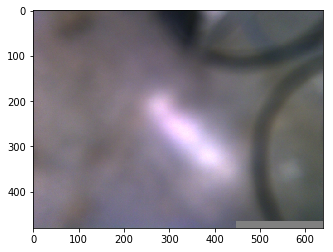

image recieved
pixel count: 0
no more objects in scene of colour: green
current angle is: 90


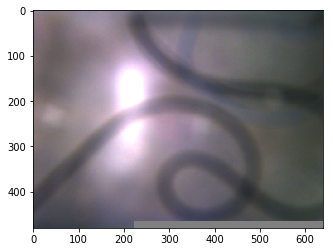

image recieved
pixel count: 0
no more objects in scene of colour: green
current angle is: 135


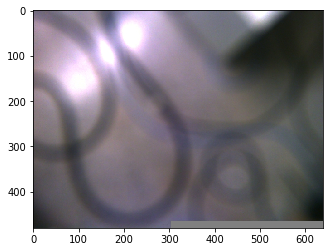

image recieved
pixel count: 0
no more objects in scene of colour: green
current angle is: 180


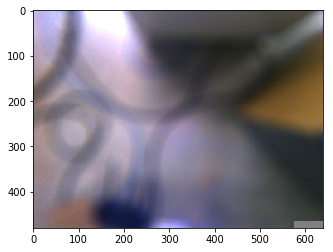

image recieved
pixel count: 0
no more objects in scene of colour: green
current angle is: 225


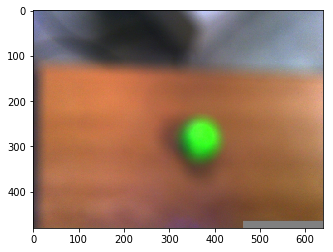

image recieved
pixel count: 6435
centerpoints at: x: 367 y: 286
top left points are: x: 367 y: 286


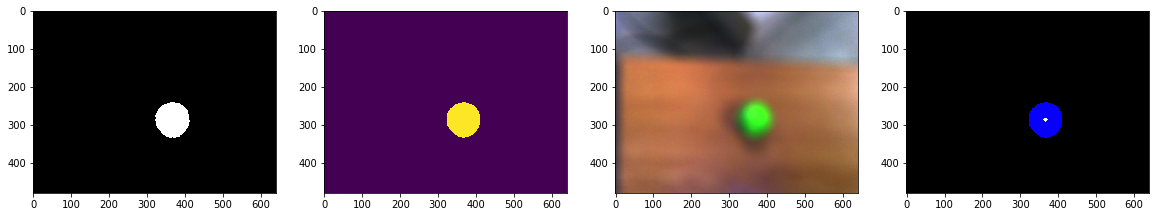

(0.029375, 0.044444444444444446)
current angle is: 270


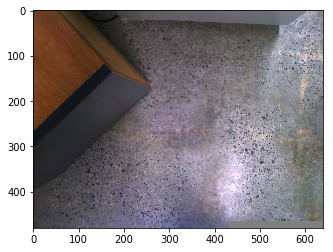

image recieved
pixel count: 0
no more objects in scene of colour: green
current angle is: 315


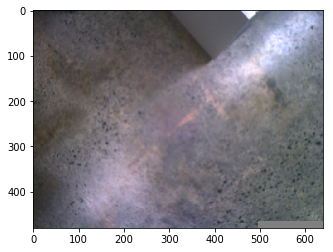

image recieved
pixel count: 0
no more objects in scene of colour: green
finished everything
moved to init position


In [81]:
%matplotlib inline

# initalise
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.7; v = 2

robotiqgrip.open_gripper()
go_to_start(rob)
[colours, bins] = teach_bins(rob)
i = 0

while True:
    if i == len(colours):
        print("finishing program")
        break
        
    go_to_start(rob)
    time.sleep(1)
    get_image()
    distance = detect_photos(colours[i])
    
    if distance == None:
        i+=1
        continue
        

    [x_dist, y_dist] = convert_to_mm(distance[0], distance[1])

    rob.translate((y_dist-0.095, x_dist, -0.33), acc=a, vel=v)

    robotiqgrip.close_gripper()
    rob.movejs([cam_init_pos, bins[i]], acc = a, vel = v, radius=0.2)
    robotiqgrip.open_gripper()

    
    
### SEARCHING THE AREA
angle = 45
while angle <= 315:
    try:
        print("current angle is: " + str(angle))
        pose = rob.getj()
        pose[0] = pose[0] + 0.785398
        rob.movej(pose, acc = a, vel = v)
        time.sleep(2)
        get_image()
        distance = detect_photos('green')

    #     change_coordinates(0.1, 0.05, angle)

        if distance == None:
            angle += 45
            continue

        [x_dist, y_dist] = convert_to_mm(distance[0], distance[1])
    #     rob.translate((y_dist-0.095, x_dist, -0.33), acc=a, vel=v)
        print(x_dist, y_dist)
        change_coordinates(x_dist, y_dist, angle)
        robotiqgrip.close_gripper()
        rob.movejs([high_point, bucket_pos], acc = a, vel = v, radius=0.2)
    #     rob.movej(bucket_pos, acc = a, vel = v)
        robotiqgrip.open_gripper()
    #     rob.movej(pose, acc = a, vel = v)
        rob.movejs([high_point, pose], acc = a, vel = v, radius=0.2)

        angle += 45
    except:
        rob = rob_connect()
    

print("finished everything")
go_to_start(rob)
rob.close()


In [3]:
## get robot back into init pos
test_robot(a = 1, v = 1)


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\61457\Anaconda3\envs\p2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\Users\61457\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 289, in run
    data = self._get_data()
  File "C:\Users\61457\Anaconda3\envs\p2\lib\site-packages\urx-0.11.0-py2.7.egg\urx\ursecmon.py", line 336, in _get_data
    tmp = self._s_secondary.recv(1024)
timeout: timed out



didnt connect, try again


No handlers could be found for logger "ursecmon"


('robot tcp is at pose: ', [-0.0005033651935022476, -1.6516311804400843, -1.2263649145709437, -1.2763083616839808, -4.723119680081503, 0.001761681167408824])


In [62]:
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.7; v = 2

pose = rob.getj()
print(pose)
# pose[0] = pose[0] + 0.785398
pose[0] = pose[0] - 6.28319

rob.movej(pose, acc = a, vel = v)

rob.close()

[6.282897472381592, -1.651595417653219, -1.2261975447284144, -1.276356045399801, -4.723047796879904, 0.001761681167408824]


In [60]:
def teach_bins(rob):
    '''
    Allows user to move robot to placement of bins
    Also need to allow user to take photo of object!??
    '''
    colours = []
    bins = []
    n_bins = int(raw_input("Please enter the number of bins you have: "))
    for i in range(n_bins):
        rob.set_freedrive(1, timeout=60)
        colours.append(raw_input("Press color of bin when complete: "))
        bins.append(rob.getj())
        
    print("Completed all bins!")
    return [colours, bins]

def get_image():
    '''
    Recieve latest image and save it in a folder
    '''
    
    image_url = "http://192.168.1.6:4242/current.jpg?type=color"
    
    resp = requests.get(image_url, stream=True)
    # Open a local file with wb ( write binary ) permission.
    img_string = 'images/latest_image.jpg'
    local_file = open(img_string, 'wb')
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    resp.raw.decode_content = True
    # Copy the response stream raw data to local image file.
    shutil.copyfileobj(resp.raw, local_file)
    # Remove the image url response object.
    del resp
    
    im = cv2.imread('images/latest_image.jpg')
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("image recieved")

def detect_photos(colour):
    '''
    Read in latest image and detect blobs of the given colour
    return the distance to the top left blob in form [X_from_center, Y_from_center] else returns None
    '''
    f = "images/latest_image.jpg"

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (70, 255, 255)
    
    ##YELLOW
    lower_yellow = (30, 100, 50)
    upper_yellow = (45, 255, 255)



    # reading in image to RGB and HSV
    img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)

    if colour == 'red':

        # Create two masks
        mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
        mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

        # XOR masks
        mask = cv2.bitwise_xor(mask1, mask2)
    elif colour == 'green':
        mask = cv2.inRange(img_HSV, lower_green, upper_green)

    elif colour == 'yellow':
        mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)


    # bitwise and with image
    result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


    # put median blur over the top
    median = cv2.medianBlur(mask,23)

    print("pixel count: " + str(cv2.countNonZero(median)))

    if cv2.countNonZero(median) < 2000:
        print("no more objects in scene of colour: " + colour)
        return None

    # find connected components
    ret, labels = cv2.connectedComponents(median)

    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #########################################################
    ## Finding Centers!
    ret,thresh = cv2.threshold(median,127,255,0)

    # find contours in the binary image
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    distance_min = 100000
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)

            distance_new = np.sqrt(cX**2 + cY**2)
            if distance_new < distance_min:
                distance_min = distance_new
                X_top_left = cX
                Y_top_left = cY

            print("centerpoints at: x: " + str(cX) + " y: " + str(cY))

    print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))

#     X_from_center = X_top_left - (640/2)
#     Y_from_center = Y_top_left - (480/2)

#     print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))

    # print out figures
    figure = plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    # mask
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 4, 2)
    # median blue
    plt.imshow(median)
    #original image
    plt.subplot(1, 4, 3)
    plt.imshow(img_RGB)
    # final 
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_img)

    plt.show()

#     return [X_from_center, Y_from_center]
    return [X_top_left, Y_top_left]

def test_robot(a = 0.2, v = 0.3):
    '''
    Test to see if robot is behaving normally
    '''
    # connecting to robot and initialising gripper
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            break
    
    robotiqgrip = Robotiq_Two_Finger_Gripper(rob)

    robotiqgrip.open_gripper()

    # move to initial position
    rob.movej(cam_init_pos, acc = a, vel = v)


    pose = rob.getj()
    print("robot tcp is at pose: ", pose)

    rob.close()

def go_to_start(rob):
    rob.movej(cam_init_pos, acc = a, vel = v)
    print("moved to init position")
    

def rob_connect():
    while(1):
        try:
            rob = urx.Robot("192.168.1.6")
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
            return rob
    



def convert_to_mm(x, y):
    '''
    return mm from center!
    '''
    x = x - (640/2)
    y = y - (480/2)
    
    
    x = ((44.0/640.0) / 100) * x
    x = x/1.1
    y = ((40.0/(480.0)) / 100) * y + 0.015
    y = y / 1.2
    
    
    return [x, y]

image recieved


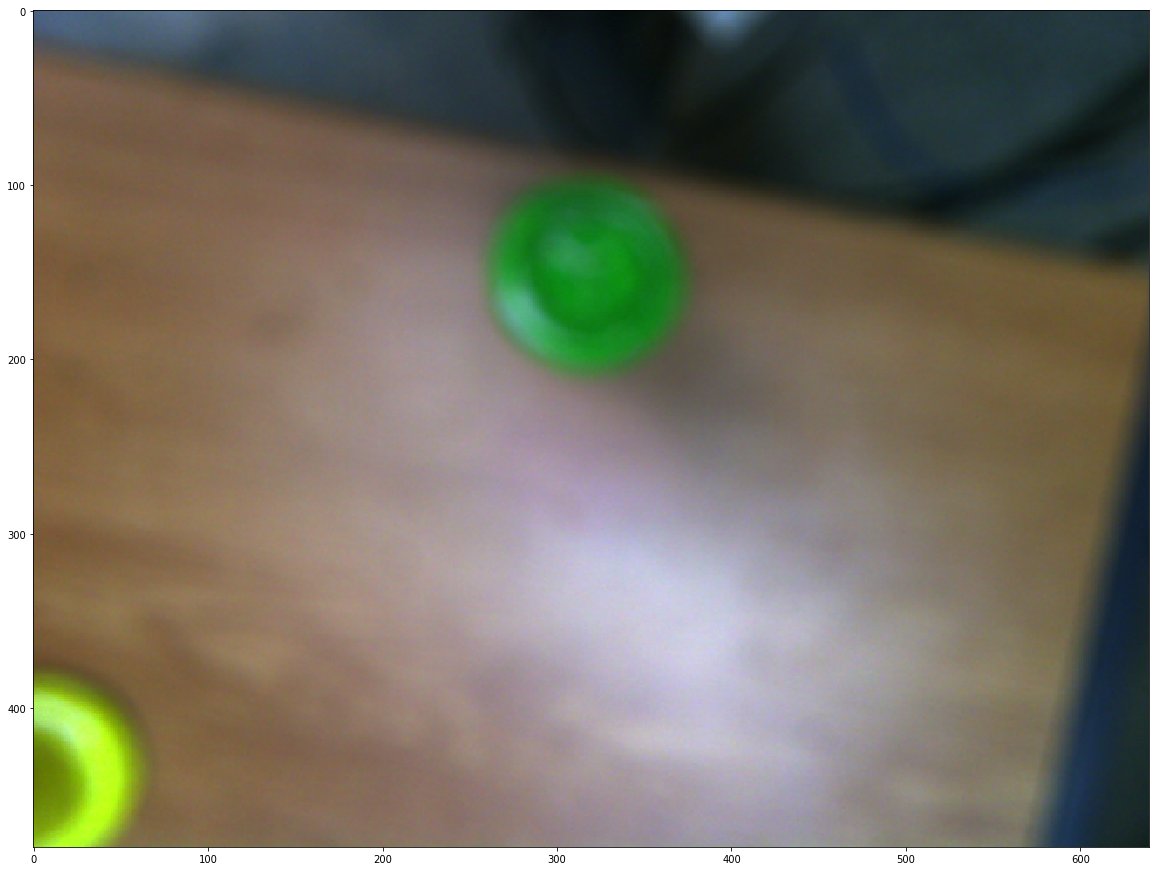

In [42]:
## CALLIBRATING IMAGE

# initalise

%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(20,30))
get_image()
img=mpimg.imread('images/latest_image.jpg')

all_val = []

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)
    [x, y] = convert_to_mm(ix, iy)
    print(x, y)
    
    
    rob = rob_connect()
    robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
    a = 0.7; v = 2
    robotiqgrip.close_gripper()
    
    rob.translate((y, x, 0), acc=a, vel=v)
    rob.translate((-0.1, 0, 0), acc=a, vel=v)
    rob.translate((0, 0, -0.33), acc=a, vel=v)
    time.sleep(1)
    rob.movej(cam_init_pos, acc = a, vel = v)
    rob.close()
    

    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()